## **Phase 3: Project Submission & Final Presentation - Progress Report**

**Group Member Names & IDs**

1. Muhammad Asad Ejaz - g202520650
2. Ahmad Al-Uthman - g199916890
3. Muhammad Marij Hashmi - g202507950

# I. Introduction & Problem Definition

The proliferation of digital payments has cemented credit cards as the dominant method for both online and in-person transactions, yet this convenience is shadowed by the growing threat of financial crime. Credit card fraud is a major and rapidly escalating issue globally, resulting in annual losses that cost financial institutions and merchants billions of dollars. The scale of this problem is underscored by the Federal Trade Commission (FTC), which reported that credit card fraud was the most common form of identity theft in 2024, accounting for over **449,000 reports** and representing an **8% increase** from the previous year. This escalating rate of fraudulent activity not only causes substantial financial damage but also severely erodes consumer trust in the financial ecosystem.

The core challenge for building a fraud detection model is the necessity of accurately modeling a **highly imbalanced dataset**. Initial exploration of the transaction data reveals an **extremely significant class imbalance**, where fraudulent transactions constitute a very minute fraction of the total records. This renders simple **accuracy** a misleading performance metric.

Our study addresses this by:
* **Primary Goal:** Developing a robust machine learning classifier to accurately and robustly identify fraud while specifically managing the class imbalance problem.
* **Supporting Sub-Goals (Data Analysis & Feature Engineering):**
    * **Behavioral Anomaly Detection:** Analyzing customer spending patterns (frequency, typical amounts) to detect significant deviations that indicate a compromised account.
    * **Contextual Transaction Risk Analysis:** Performing feature engineering that is more indicative of fraud risk by incorporating factors like **time of day (e.g., late-night transactions), population of the city, and the typical transaction volume** of the merchant's area.
    * **Transaction Classification:** Categorizing transactions by merchant type to provide critical context for risk assessment.
  
The primary objective of this project is to **develop, implement, and rigorously evaluate a supervised machine learning system** capable of classifying credit card transactions as either **legitimate (non-fraudulent)** or **fraudulent** with **high reliability, particularly in the face of extreme class imbalance**.

Specifically, the system must achieve:
1.  **High Recall (Sensitivity):** Maximizing the detection of true fraudulent transactions to prevent financial loss.
2.  **High Precision:** Minimizing false positives (flagging legitimate transactions as fraud) to avoid customer inconvenience.
3.  **Advanced Modeling:** **Explore and evaluate ensemble methods (e.g., Random Forest or XGBoost)**, which are inherently more robust than single classifiers for complex, imbalanced datasets.
4.  **Comparative Analysis:** Evaluate the trade-offs of at least three classification algorithms specifically tuned and sampled for highly imbalanced data.


**Project Environment Setup and Library Imports**

This section details the necessary libraries and initial configurations for the project. The imports are grouped by their primary function (Data Handling, Modeling, Preprocessing, Evaluation, and Imbalance Handling) to ensure clarity for all team members throughout the project lifecycle.

In [ ]:
# --- 1. Core Data Handling and Visualization ---
import pandas as pd # Data manipulation and analysis
import numpy as np # Numerical operations, especially for arrays
import matplotlib.pyplot as plt # Standard plotting library
import seaborn as sns # Enhanced statistical data visualization

# --- 2. Google Colab / Kaggle Tools ---
import kagglehub # Tool for easily downloading Kaggle datasets
from kagglehub import KaggleDatasetAdapter # Specific adapter for dataset access

# --- 3. Scikit-learn: Model Selection, Pipelines, and Basic Classifiers ---
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV # Splitting data, cross-validation
from sklearn.pipeline import Pipeline # Sequential application of transforms and estimators
from sklearn.neighbors import KNeighborsClassifier # Our first classification algorithm (K-NN)
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.base import clone # Utility for cloning estimators
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier


# --- 4. Scikit-learn: Preprocessing and Feature Engineering ---
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler # Standard scaling techniques
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder # Encoding for categorical features
from sklearn.compose import ColumnTransformer # Applying different transformers to different columns
from sklearn.preprocessing import FunctionTransformer # Wrapping custom functions into scikit-learn transformers
from sklearn.decomposition import PCA # Principal Component Analysis (dimensionality reduction)
from pandas.plotting import scatter_matrix # Utility for pairwise scatter plots

import xgboost as xgb

# --- 5. Model Evaluation Metrics ---
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, # Basic classification metrics
    precision_score, recall_score, f1_score, # Metrics critical for imbalanced data
    roc_curve, auc, precision_recall_curve, classification_report # Curve metrics and comprehensive report
)

# --- 6. Imbalance Handling (via imblearn - needed for Phase 3 but imported now) ---
# Note: These are for advanced handling of the class imbalance problem
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE # Oversampling techniques
from imblearn.under_sampling import RandomUnderSampler # Undersampling technique
# from imblearn.pipeline import make_pipeline # Special pipeline for integrating sampling steps

# --- 7. Domain-Specific (Geocoding library, currently disabled but noted) ---
# from geopy.geocoders import Nominatim # Library for converting addresses/coords (removed from analysis but kept for reference)


try:
    import google.colab
    from google.colab.data_table import DataTable # Improves display of large DataFrames in Colab
    DataTable.max_columns = 30 # Set max columns for display
    IN_COLAB = True
except:
    IN_COLAB = False

import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# Load the latest version
if IN_COLAB == True:
  data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "priyamchoksi/credit-card-transactions-dataset",
    "credit_card_transactions.csv",
    # Provide any additional arguments like
    # sql_query or pandas_kwargs. See the
    # documenation for more information:
    # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
  )
else:
  data = pd.read_csv('./dataset/credit_card_transactions.csv')
num_records = len(data)
features = data.keys()
num_features = len(features)
target = data['is_fraud']

print(num_records)
print(num_features)

100%|██████████| 145M/145M [00:01<00:00, 137MB/s]

Extracting zip of credit_card_transactions.csv...


1296675
24


# II. Dataset Description and Evidence of Initial Exploration

**1. Dataset and Source**

* **Dataset:** Credit Card Transactions
* **Source:** `https://www.kaggle.com/datasets/priyamchoksi/credit-card-transactions-dataset`
* **Description:** This labeled dataset has over **1.29 million records with 24 features**, including transaction times, amounts, and location data. Its large size and labeled nature make it ideal for supervised learning.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

## 2. Data Information and Variable Description

The dataset, consisting of **$1,296,675$ records** across **$24$ features**, is highly detailed. An initial review of the `data.info()` output shows that most columns are fully populated, with the exception of `merch_zipcode`.

The column types are distributed as follows:
* **`float64`**: 6 columns
* **`int64`**: 6 columns
* **`object` (strings)**: 12 columns

### Variable Descriptions

| Column Name | Dtype | Description | Relevance to Fraud Detection |
| :--- | :--- | :--- | :--- |
| **0. Unnamed: 0** | `int64` | Unnamed index column (likely a residual column from CSV export). | **Low.** Should be dropped. |
| **1. trans\_date\_trans\_time** | `object` | Full timestamp of the transaction (Date and Time). | **High.** Essential for temporal analysis (time of day, day of week). |
| **2. cc\_num** | `int64` | **Credit Card Number.** Identifies the cardholder/account. | **High.** Crucial for deriving behavioral features (transaction velocity, frequency per card). |
| **3. merchant** | `object` | Name of the merchant where the transaction occurred. | **High.** Needed for fraud risk scoring and transaction categorization. |
| **4. category** | `object` | Category of the purchase (e.g., 'gas\_transport', 'grocery\_pos', 'misc\_net'). | **High.** Vital for Transaction Classification sub-goal and checking for unusual spending. |
| **5. amt** | `float64` | **Transaction Amount.** The monetary value of the purchase. | **High.** Core feature for anomaly and behavioral detection (e.g., unusually high amounts). |
| **6. first** | `object` | Cardholder's First Name. | **Low.** Potentially useful for linking to other customer data, but not directly for transaction risk. |
| **7. last** | `object` | Cardholder's Last Name. | **Low.** Same as `first`. |
| **8. gender** | `object` | Cardholder's Gender. | **Medium.** Useful for customer segmentation/profiling. |
| **9. street** | `object` | Cardholder's Street Address. | **Low.** Included in the full location data, but raw address text is typically too high-cardinality for direct use. |
| **10. city** | `object` | Cardholder's City of residence. | **Low/Medium.** Useful for local risk scoring. |
| **11. state** | `object` | Cardholder's State of residence. | **Medium.** Useful for regional fraud trend analysis. |
| **12. zip** | `int64` | Cardholder's ZIP code. | **Medium.** |
| **13. lat** | `float64` | Cardholder's residence Latitude. | **Low.** Residence location is static; only valuable for comparison with merchant location. |
| **14. long** | `float64**` | Cardholder's residence Longitude. | **Low.** Residence location is static; only valuable for comparison with merchant location. |
| **15. city\_pop** | `int64` | **Population of the cardholder's city.** | **High.** Critical feature for our **Contextual Risk Analysis** sub-goal (e.g., transactions in low-pop areas). |
| **16. job** | `object**` | Cardholder's Occupation. | **Medium.** Useful for demographic/risk profiling. |
| **17. dob** | `object**` | Cardholder's Date of Birth. | **High.** Essential for calculating **Cardholder Age** (a valuable risk feature). |
| **18. trans\_num** | `object` | **Unique Transaction Identifier.** | **Low.** Useful for indexing/tracking but not a predictive feature. |
| **19. unix\_time** | `int64` | Transaction time as Unix timestamp (seconds since epoch). | **Low.** A long number of seconds of date since 1970, which might not be helpful as much as compared to the previous column for transaction date and time. |
| **20. merch\_lat** | `float64` | Merchant's location Latitude. | **Low.** Zipcode would be more indicative to cover areas of risk. |
| **21. merch\_long** | `float64**` | Merchant's location Longitude. | **Low.** Zipcode would be more indicative to cover areas of risk. |
| **22. is\_fraud** | `int64` | **TARGET VARIABLE.** $1$ = Fraudulent, $0$ = Legitimate. | **Highest.** The classification goal. |
| **23. merch\_zipcode** | `float64` | Merchant's ZIP code. (**195,973 missing values**) | **Medium.** Can be used for localized risk scoring after imputation/handling of missing data. |

In [ ]:
data[data['is_fraud'] == True].head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1,28644.0
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1,78055.0
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1,78039.0
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1,28777.0
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1,78006.0


<Axes: >

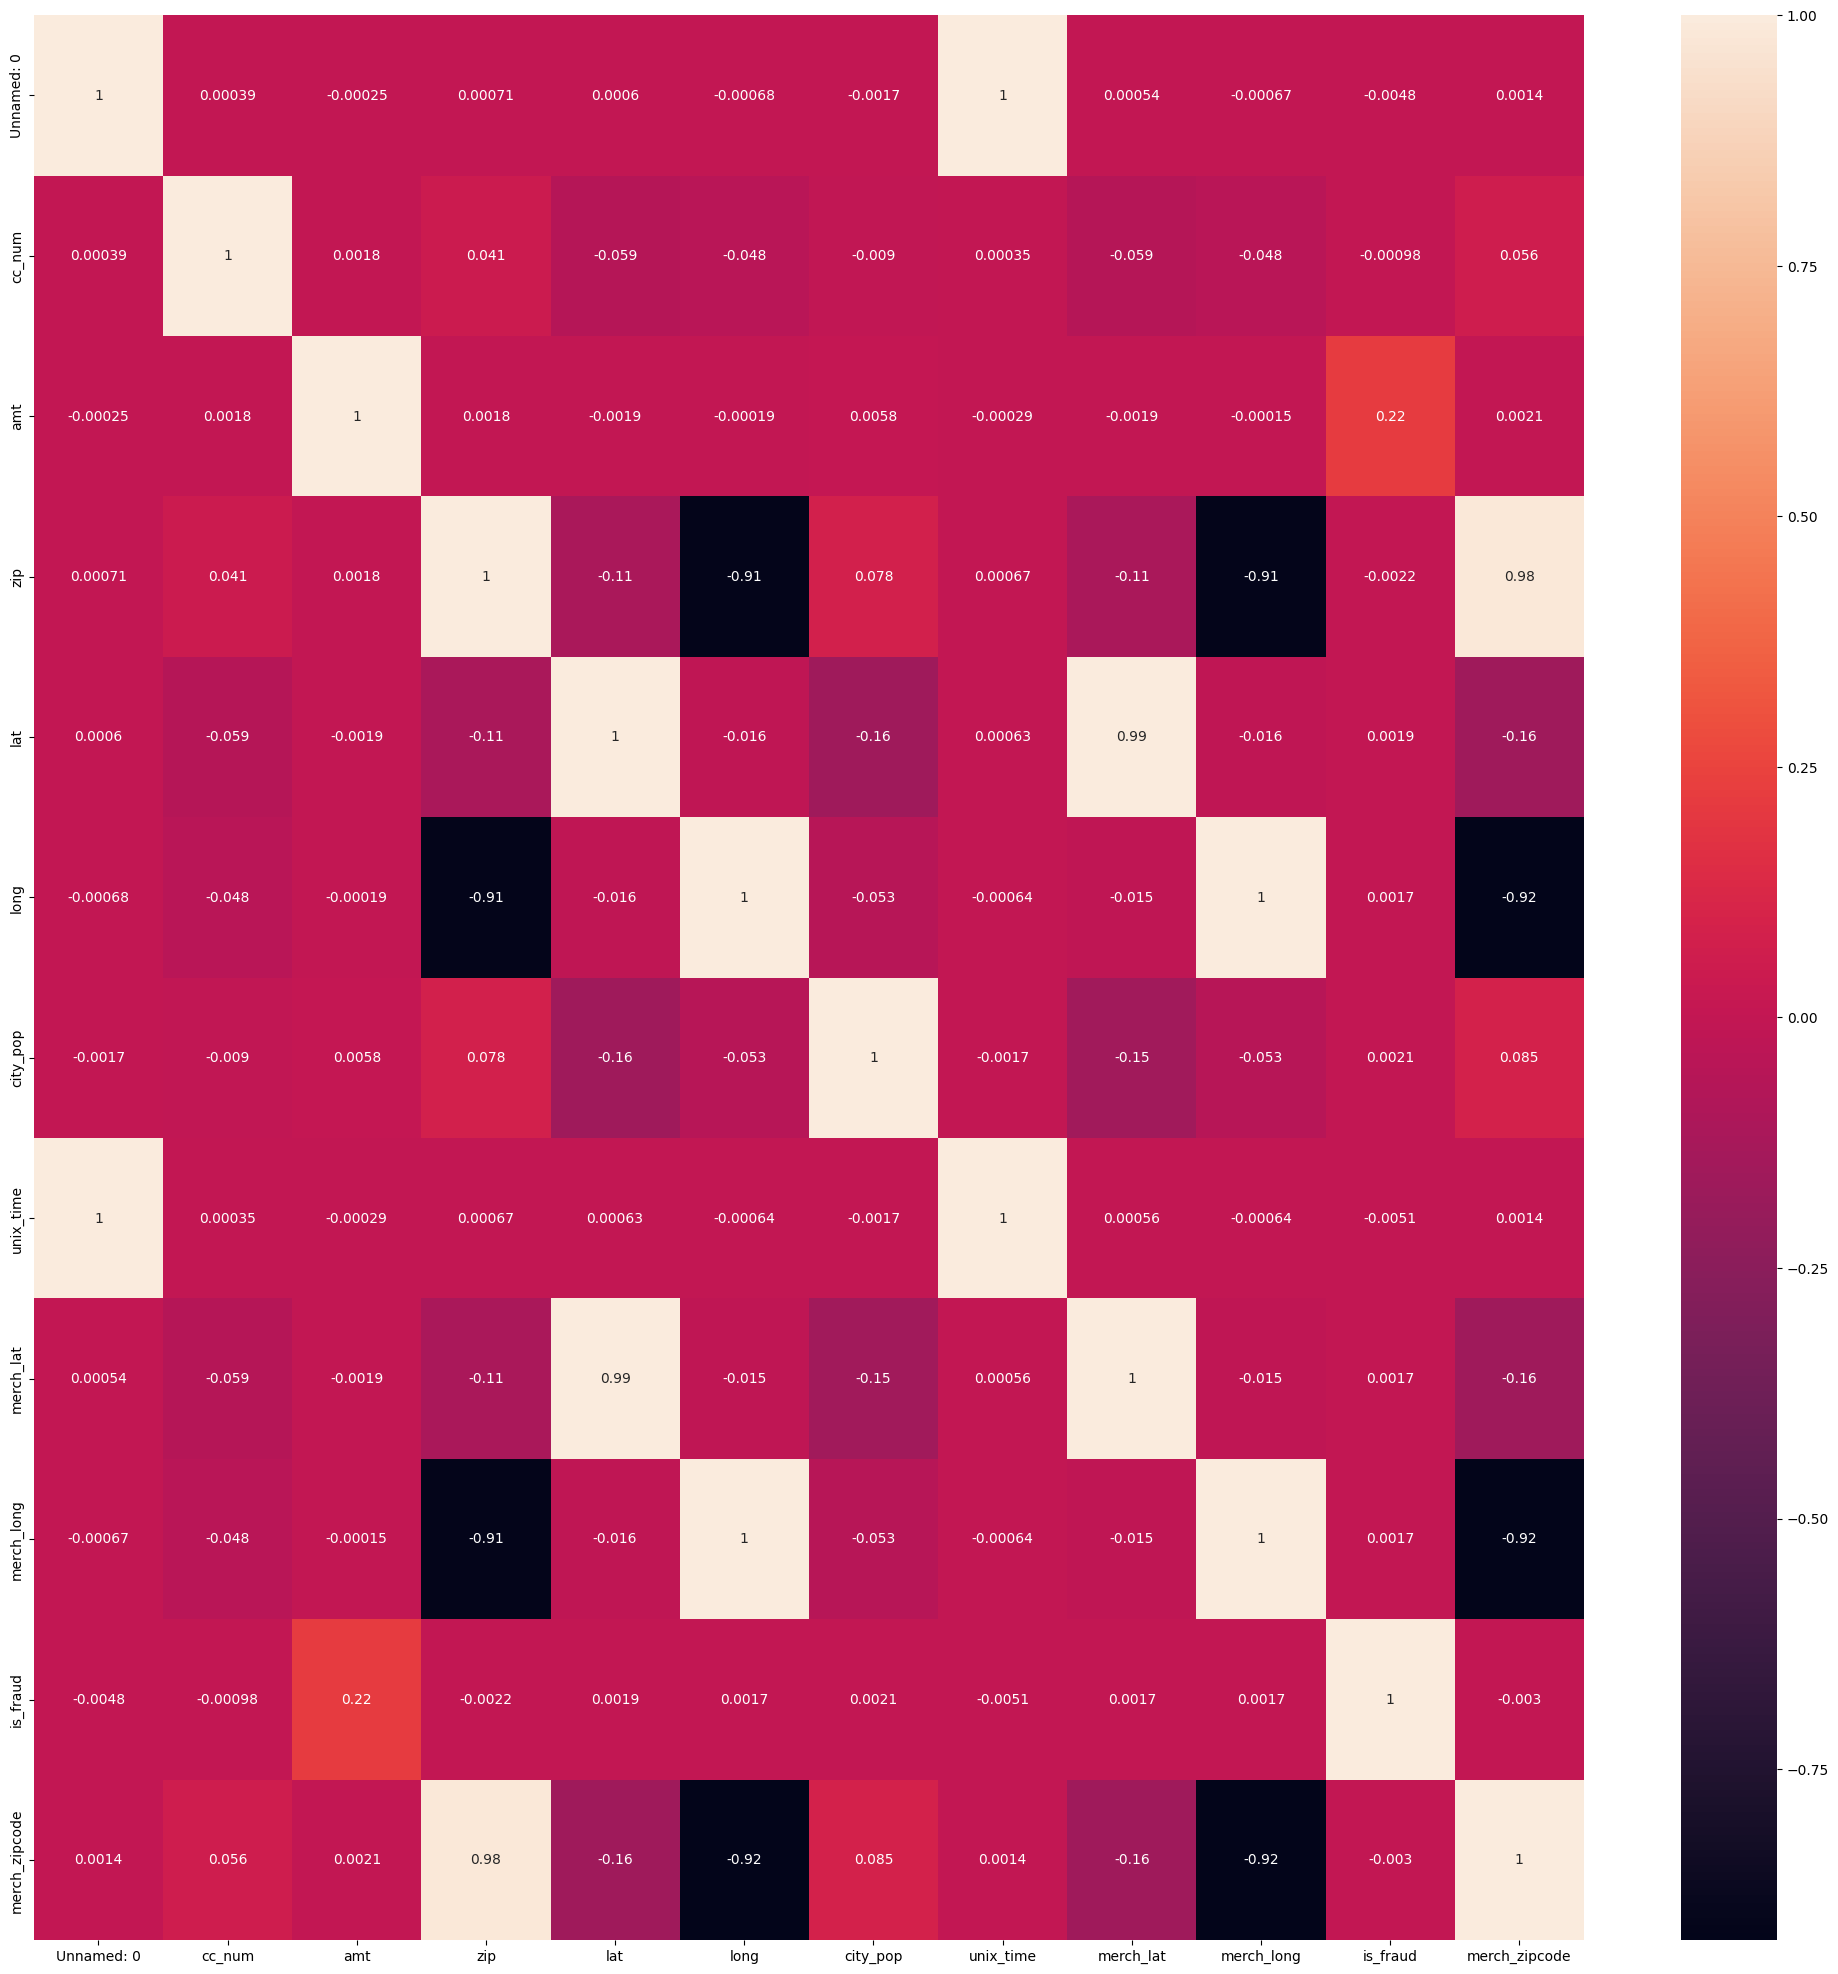

In [ ]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(numeric_only=True),annot= True)

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


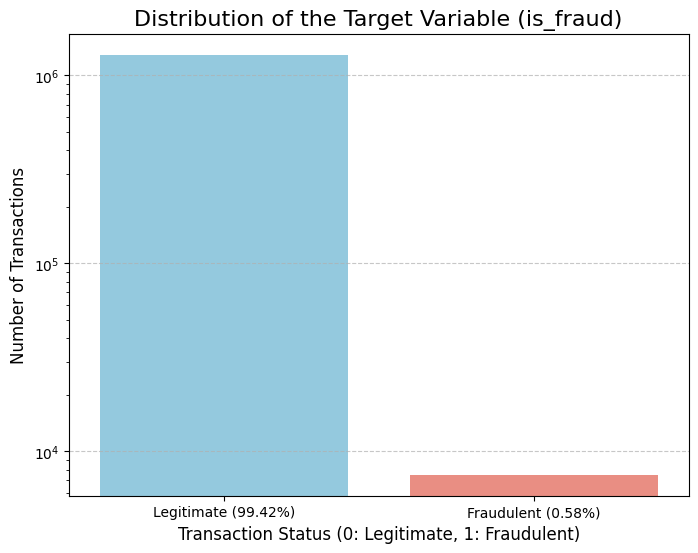

In [ ]:
print(target.value_counts(normalize=True) *100)

# Create a count plot to visualize the imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='is_fraud', data=data, palette=['skyblue', 'salmon'])
plt.title('Distribution of the Target Variable (is_fraud)', fontsize=16)
plt.xlabel('Transaction Status (0: Legitimate, 1: Fraudulent)', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Legitimate (99.42%)', 'Fraudulent (0.58%)'])
plt.yscale('log') # Use a log scale on the Y-axis to visualize the minority class
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 3. Analysis of Class Imbalance (Target Variable)

The analysis of the target variable, is_fraud, confirms the severe challenge of class imbalance in our dataset, as noted in the problem statement. This is a critical factor influencing our entire modeling approach.

**Key Findings and Implications:**

1. Legitimate Transactions (Class 0): Account for 99.42% of all records.

2. Fraudulent Transactions (Class 1): Account for only 0.58% of all records.

3. This means that for every 1000 transactions, fewer than 6 are fraudulent.

This imbalance confirms that simple Accuracy is misleading. A trivial model that always predicts "Not Fraud" would achieve an accuracy of 99.42%, yet would be completely useless in a real-world application (Recall of 0%). We must therefore prioritize Precision, Recall, F1-Score, and the PR-AUC (Area Under the Precision-Recall Curve).

# II. Code & Justification of Each Step in Project

**1. Data Preprocessing**

This section covers the initial data cleaning, transformation, and feature engineering necessary to prepare the dataset for machine learning models. We focus on transforming time-related fields into usable numerical features and handling the high-cardinality categorical data using an OrdinalEncoder as well scaling for high numeric features.

In [ ]:
processed_data = data.copy()

In [ ]:
processed_data['trans_date_trans_time'] = pd.to_datetime(processed_data['trans_date_trans_time'])
processed_data['date'] = processed_data['trans_date_trans_time'].dt.date
processed_data['day_of_week'] = processed_data['trans_date_trans_time'].dt.dayofweek + 1
processed_data['month'] = processed_data['trans_date_trans_time'].dt.month
processed_data['hour_of_day'] = processed_data['trans_date_trans_time'].dt.hour + 1
processed_data['dob'] = pd.to_datetime(processed_data['dob'])
processed_data['age'] = processed_data['trans_date_trans_time'] - processed_data['dob']
processed_data['age'] = processed_data['age'].apply(lambda x: (x.days/365)).astype(int)

**Justification: Temporal and Demographic Feature Extraction**

This initial transformation block focuses on extracting crucial temporal and demographic features from raw object columns. This step is vital because machine learning models cannot interpret raw date strings; they require numerical features to capture time-dependent and behavioral patterns.

| Feature Group | Code Action | Rationale & Fraud Relevance |
| :--- | :--- | :--- |
| Temporal Context | Convert trans_date_trans_time to datetime and extract date, day_of_week, month, and hour_of_day. | High Relevance. Fraudulent activity is highly dependent on time. Extracting these features allows the model to capture patterns such as: high fraud rates on weekends (day_of_week), late-night transactions (hour_of_day), or seasonal anomalies (month). These features directly support the Contextual Risk Analysis sub-goal by transforming static time data into actionable risk signals. |
| Demographic Feature | Convert dob to datetime, calculate the time difference, and derive the customer's age in years. | High Relevance. The age of the cardholder provides a stable demographic profile, which is key for Behavioral Anomaly Detection. A deviation from the established spending habits of a specific age demographic can be a strong fraud signal, making the age integer usable for scaling and modeling. |

In [ ]:
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].fillna(0)
processed_data['merch_zipcode'] = processed_data['merch_zipcode'].astype(int)

**Justification: Missing value imputation for missing merch_zipcode**

This step addresses the significant data quality issue identified in the initial exploration: the $\text{merch_zipcode}$ column contains a large number of missing values.

| Step | Rationale | Fraud Relevance |
| :--- | :--- | :--- |
| Imputation with 0 | We impute the missing float values in $\text{merch_zipcode}$ with 0. This approach avoids the bias that would be introduced by using the mean or median (which would represent a common location). | Creating a Distinct Risk Category. Imputing with a specific, non-existent ZIP code value ($\mathbf{0}$) allows the machine learning model to treat all missing merchant locations as their own distinct categorical risk group. Transactions where the merchant's location is unknown often carry an elevated, unique risk profile that the model needs to learn |
| Type Conversion | Converting the column to int is necessary for applying the OrdinalEncoder in the subsequent transformation step, ensuring consistency with other integer-based identifier features. | Facilitates the use of this location-based feature in modeling, supporting the Contextual Risk Analysis sub-goal. |

In [ ]:
processed_data['gender'] = processed_data['gender'].map({'M':1, 'F':0})

In [ ]:
processed_data['num_of_tx_day'] = (processed_data.groupby(['cc_num','date'])['cc_num'].transform('count'))

**Justification: Transaction Velocity Feature**

This step creates a crucial Behavioral Anomaly feature known as Transaction Velocity.

| Step | Rationale | Fraud Relevance |
| :--- | :--- | :--- |
| Grouping & Counting | We group the data by the unique Credit Card Number (cc_num) and the Transaction Date (date). The .transform('count') function then broadcasts the count back to every row belonging to that specific group. | High Relevance (Behavioral Analysis). This feature measures the number of transactions a single card made on a specific day. A sudden, massive surge in daily transaction count, especially followed by a large transaction, is a classic indication that the card has been compromised (e.g., card-testing schemes or fraudulent high-volume purchases). This feature directly supports the Behavioral Anomaly Detection sub-goal. |
| Feature Type | The resulting feature is numerical and directly integrated into the dataset, ready for scaling and modeling. | Provides the model with a quantifiable measure of the cardholder's historical activity rate, significantly improving predictive power. |

In [ ]:
def coord_dist(row):
    p1 = np.array([row['lat'],row['long']])
    p2 = np.array([row['merch_lat'],row['merch_long']])
    dist_deg = np.linalg.norm(p2 - p1)
    dist_km = dist_deg * 111
    return dist_km

processed_data['cust_merch_dist'] = processed_data.apply(coord_dist,axis=1)

**Justification: Customer-Merchant Distance**

Although raw geographic coordinates ($\text{lat}$, $\text{long}$, etc.) were dropped from the final feature set due to data quality issues, we retain and use the calculated distance between the cardholder's residence and the merchant's location at the time of the transaction. This feature provides a powerful, single numerical measure of geographic relationship.

| Feature | Rationale | Fraud Relevance |
| :--- | :--- | :--- |
| cust_merch_dist | The function calculates the Euclidean distance between the two sets of coordinates ($P_1$: customer, $P_2$: merchant). The result in degrees is converted to approximate kilometers (using the factor 111 km/degree of latitude). | High Relevance (Geographic Anomaly). This feature is a direct measure of transaction plausibility. An unusually large distance (e.g., a card based in New York showing a transaction in California) or a distance inconsistent with a cardholder's typical purchasing range is a strong indicator of card-not-present fraud or physical card theft. This strongly supports the Contextual Transaction Risk Analysis sub-goal. |

In [ ]:
cat_col = ['cc_num','category','job', 'merchant','state']
# cat2_col = ['']
drop_col = ['Unnamed: 0','trans_num','first','last','dob',
            'street','city','zip', 'merch_zipcode'
            ,'lat','long','unix_time','merch_lat','merch_long', 'trans_date_trans_time', 'date']
scale_col = ['amt', 'city_pop','cust_merch_dist']
ct = ColumnTransformer([
        ('cat', OrdinalEncoder(),cat_col),
        ('scale', StandardScaler(), scale_col),
        ('drop','drop',drop_col),
        ], remainder='passthrough')
ct.set_output(transform='pandas')
processed_data = ct.fit_transform(processed_data)
for col in processed_data.columns:
  processed_data.rename(columns={col:col.replace('remainder__','')}, inplace=True)


**Justification: Final Preprocessing Pipeline**

This section defines the final data processing pipeline using the ColumnTransformer to handle different column types simultaneously, ensuring all data is numerical and properly scaled for the machine learning models.

| Action | Columns | Rationale & Fraud Relevance |
| :--- | :--- | :--- |
| OrdinalEncoder (cat) | cc_num, category, job, merch_zipcode, merchant | Applied to high-cardinality categorical features. Due to the dataset's size ($\approx 1.3$ million records), Ordinal Encoding is used as a pragmatic choice over One-Hot Encoding to avoid generating thousands of columns, which would cause significant memory constraints and lead to model instability. This conversion allows the model to utilize these identifiers. |
| Standard Scaler (scale) | amt, city_pop, cust_merch_dist | Normalization. These features have vastly different scales. Standardizing them (mean=0, variance=1) is crucial to prevent features with larger numerical ranges (like $\text{city_pop}$) from dominating distance-based models (KNN) and regularized models (LR, SVM). |
| Drop (drop) | Identifiers & Raw Geospatial Coordinates | Feature Selection. Irrelevant identifiers (Unnamed: 0, $\text{trans_num}$) are removed. Raw geospatial coordinates (lat, $\text{long}$, $\text{merch_lat}$, $\text{merch_long}$) and detailed location strings ($\text{street}$, $\text{city}$) are dropped based on preliminary analysis showing null values and the strategic pivot to use the robust engineered features ($\text{city_pop}$, $\text{day_of_week}$, $\text{num_of_tx_day}$) instead.|
| Remainder = 'passthrough' | All newly created features (e.g., age, $\text{num_of_tx_day}$, $\text{hour_of_day}$, $\text{is_fraud}$) | Preservation. Ensures that all the engineered, numerical features created in the previous steps (like age, gender, and velocity features) are retained in the final processed dataset. |

**2. Final Feature Set**

In [ ]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   cat__cc_num             1296675 non-null  float64
 1   cat__category           1296675 non-null  float64
 2   cat__job                1296675 non-null  float64
 3   cat__merchant           1296675 non-null  float64
 4   cat__state              1296675 non-null  float64
 5   scale__amt              1296675 non-null  float64
 6   scale__city_pop         1296675 non-null  float64
 7   scale__cust_merch_dist  1296675 non-null  float64
 8   gender                  1296675 non-null  int64  
 9   is_fraud                1296675 non-null  int64  
 10  day_of_week             1296675 non-null  int64  
 11  month                   1296675 non-null  int32  
 12  hour_of_day             1296675 non-null  int64  
 13  age                     1296675 non-null  int64  
 14  nu

The final feature set for your Machine Learning model is composed of $\mathbf{15}$ features and one target feature, strategically engineered to maximize signal detection while minimizing data quality issues and the negative impact of high cardinality.

**3. Model Training**

Our main approach is **supervised classification**. Recognizing the severe **class imbalance** ($\mathbf{0.58\%}$ fraud rate), we plan to implement and compare the performance of several algorithms, focusing on their suitability for high-dimensional, imbalanced data.

| Algorithm | Justification for Selection |
| :--- | :--- |
| **1. Support Vector Machines (SVM)** | **Effective in High Dimensions:** SVMs are powerful classifiers that work well by finding the optimal hyperplane to separate classes. Using a kernel trick, SVMs can effectively model **complex, non-linear relationships** often present in transaction data, providing a strong contrast to the linear performance of LR. |
| **3. Ensemble Method (e.g., Random Forest / XGBoost)** | **Robustness & Imbalance Handling:** Ensemble methods are inherently more **robust** and less prone to overfitting than single models. They are essential for this project as they can combine predictions from multiple sub-models, leading to better overall accuracy and stability, particularly when dealing with **imbalanced classes** (a critical project objective). |

The next phase of the project will focus entirely on **model training and evaluation** using a benchmark model (Logistic Regression).

In [ ]:
processed_data.drop(axis=1, columns='is_fraud', inplace=True)
X_train, X_test, y_train, y_test = train_test_split(processed_data, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target)
print(f'X train shape {X_train.shape}')
print(f'X test shape {X_test.shape}')
print(f'y train shape {y_train.shape}')
print(f'y test shape {y_test.shape}')

X train shape (1037340, 14)
X test shape (259335, 14)
y train shape (1037340,)
y test shape (259335,)


In [ ]:
# Setup: Define the Stratified K-Fold cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


The next section details the hyperparameter tuning of the chosen models. The parameters were tuned using GridSearchCV with a 5 split stratified k-fold. The result of the tuning is as follows.

Model|Parameters Tested|Best Parameters
-|-|-
Histogram Based Gradient Boosting| 'max_leaf_nodes':[50,100,150]<br>'max_depth':[50,100,150]<br>'l2_regularization':[0.5,1,2]|'l2_regularization': 2, 'max_depth': 150, 'max_leaf_nodes': 100
XGBoost | 'min_child_weight': [1, 5, 10]<br>'gamma': [0.5, 1, 1.5, 2, 5]<br>'subsample': [0.6, 0.8, 1.0]<br>'colsample_bytree': [0.6, 0.8, 1.0]<br>'max_depth': [3, 4, 5]<br>'scale_pos_weight': [5,10,15]| 'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 5, 'scale_pos_weight': 15, 'subsample': 1.0
Linear SVC|'tol': [0.0001, 0.001, 0.01, 0.1]<br>'C': [0.1, 0.5, 1]<br>'max_iter':[500, 1000, 2000]|'C': 0.1, 'max_iter': 500, 'tol': 0.0001


In [ ]:
# models = [
#     {'name':'LogisticRegrssion','model':LogisticRegression(penalty='elasticnet',solver='saga'),'params':{
#         'l1_ratio':[0,0.25,0.5,0.75,1],
#         'max_iter':[50,100,150]
#     }},
#     {'name':'HistGradBoost','model':HistGradientBoostingClassifier(),'params':{
#         'max_leaf_nodes':[50,100,150],
#         'max_depth':[50,100,150],
#         'l2_regularization':[0.5,1,2]}},
#     {'name':'XGBoost','model':xgb.XGBClassifier(booster='gbtree', tree_method="hist"),'params': {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5],
#         'scale_pos_weight': [5,10,15]}},
#     {'name':'SVM','model':LinearSVC(loss='hinge', random_state=RANDOM_STATE),'params':{
#         'tol': [0.0001, 0.001, 0.01, 0.1],
#         'C': [0.1, 0.5, 1],
#         'max_iter':[500, 1000, 2000]
#     }},
# ]

# for model in models:

#     print(f'------------------------------{model['name']}--------------------------------')

#     pipe = Pipeline([
#         ('ct',ct),
#         ('gs', GridSearchCV(estimator=model['model'],param_grid=model['params'],cv=skf, scoring='recall'))
#         ])

#     train_pipe = clone(pipe)
#     y_pred = train_pipe.fit(X_train,y_train).predict(X_test)
#     print("Best Parameters:", train_pipe.named_steps['gs'].best_params_)
#     print(f'{model['name']} recall score is {recall_score(y_true=y_test,y_pred=y_pred):0.5f}')
#     print(f'{model['name']} precision score is {precision_score(y_true=y_test,y_pred=y_pred):0.5f}')
#     conf_matrix = confusion_matrix(y_true=y_test,y_pred = y_pred)
#     ConfusionMatrixDisplay(conf_matrix).plot()
#     plt.show()

#     class_report = classification_report(y_test,y_pred)
#     print(class_report)

#     fpr, tpr, ftthresholds = roc_curve(y_test,y_pred)
#     roc_auc = auc(fpr,tpr)
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, '.--', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
#     prec, recall, prthresholds = precision_recall_curve(y_test,y_pred)
#     pr_auc = auc(recall,prec)
#     plt.title('Precision Recall')
#     plt.plot(recall, prec, '.--',label = 'AUC = %0.2f' % pr_auc)
#     plt.legend(loc = 'lower left')
#     plt.ylabel('Precision')
#     plt.xlabel('Recall')
#     plt.show()

**Justification for Using Grid Search Cross-Validation**

1. Guaranteeing Optimal Model Configuration

The primary justification for choosing $\text{GridSearchCV}$ over faster methods like $\text{RandomizedSearchCV}$ is its exhaustive nature:Exhaustive Search: $\text{GridSearchCV}$ systematically tests every single possible combination of the defined hyperparameters ($\text{l1_ratio}$, $\text{max_iter}$, $\text{max_depth}$, etc.).Academic Rigor: For a project seeking to define the best possible performance for comparative evaluation, Grid Search guarantees that the true global optimum within the defined search space is found for each model (Logistic Regression, XGBoost, etc.). This ensures that the final model comparison is based on the highest achievable performance for each algorithm.

2. Robustness Against Class Imbalance

The setup integrates Grid Search with other critical components to manage the $\mathbf{0.58\%}$ fraud rate:Stratified Cross-Validation: The use of cv=skf (StratifiedKFold) ensures that the severe class imbalance is perfectly preserved across every single internal validation fold. This prevents training subsets from accidentally containing zero or too few fraud cases, which would derail the tuning process.Objective Scoring: By setting scoring='recall', the entire search process is ruthlessly focused on the project's most critical objective: maximizing the detection rate of fraudulent transactions (minimizing False Negatives). This guarantees that the chosen parameters are the most effective at achieving the business goal.

3. Workflow Integration (The Pipeline)

Using Grid Search within the Pipeline (pipe = Pipeline([('ct', ct), ('gs', GridSearchCV(...))])) is crucial:Preventing Data Leakage: The Pipeline ensures that the proper preprocessing (ct) is applied consistently to the training folds during the search, preventing data leakage and guaranteeing a fair, reproducible evaluation across all parameter tests.While $\text{GridSearchCV}$ is very slow considering the large size of the dataset, its use for this project is justified by the need for maximal performance validation and academic certainty that the chosen model configurations are the best possible given the available data and algorithms

Training HistGradientBoostingClassifier with optimal parameters...
------------------------------HistGradBoost (Final)--------------------------------
HistGradBoost (Final) Recall Score: 0.85743
HistGradBoost (Final) Precision Score: 0.97205


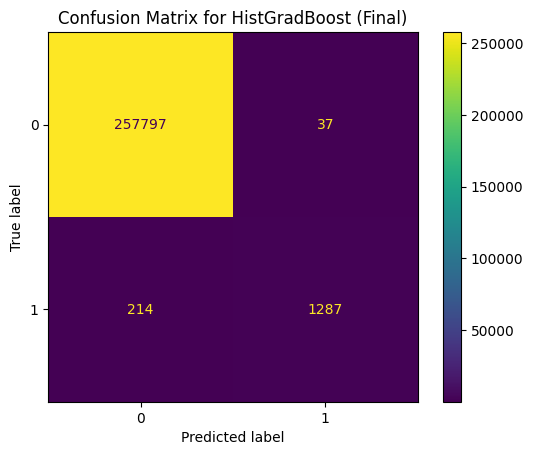

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.97      0.86      0.91      1501

    accuracy                           1.00    259335
   macro avg       0.99      0.93      0.96    259335
weighted avg       1.00      1.00      1.00    259335



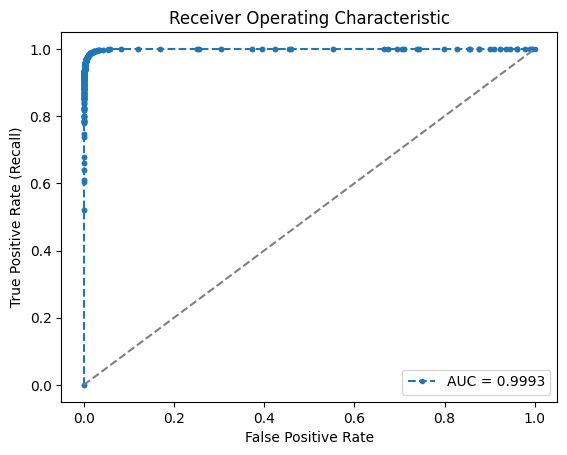

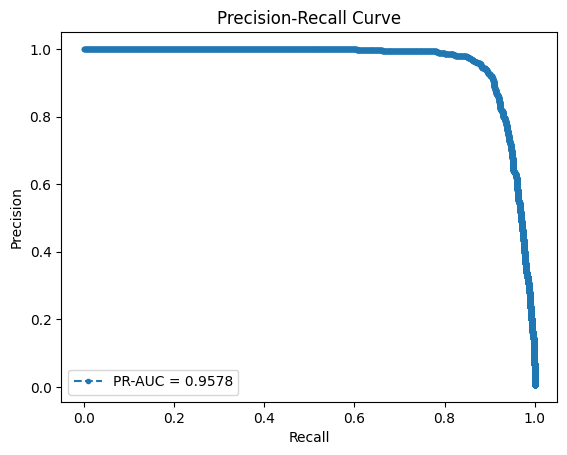

In [ ]:
# Optimal parameters
BEST_HGB_PARAMS = {
    'l2_regularization': 2,
    'max_depth': 150,
    'max_leaf_nodes': 100
}

# 1. Define the Final HGBoost Model
final_hgb_model = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    l2_regularization=BEST_HGB_PARAMS['l2_regularization'],
    max_depth=BEST_HGB_PARAMS['max_depth'],
    max_leaf_nodes=BEST_HGB_PARAMS['max_leaf_nodes']
)

# 2. Train the Model Directly (No CV needed)
print("Training HistGradientBoostingClassifier with optimal parameters...")
final_hgb_model.fit(X_train, y_train)

# 3. Predict on the Test Set
y_pred_hgb = final_hgb_model.predict(X_test)
y_proba_hgb = final_hgb_model.predict_proba(X_test)[:, 1]

# 4. Output Results
model_name = "HistGradBoost (Final)"
print(f"------------------------------{model_name}--------------------------------")
print(f'{model_name} Recall Score: {recall_score(y_true=y_test, y_pred=y_pred_hgb):0.5f}')
print(f'{model_name} Precision Score: {precision_score(y_true=y_test, y_pred=y_pred_hgb):0.5f}')

# --- Evaluation Plots ---
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_hgb)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

class_report = classification_report(y_test, y_pred_hgb)
print(class_report)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_hgb)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

# Precision-Recall Curve (Primary Imbalance Metric)
prec, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_hgb)
pr_auc = auc(recall, prec)
plt.title('Precision-Recall Curve')
plt.plot(recall, prec, '.--', label = 'PR-AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**Justification for HistGradientBoostingClassifier**

The HistGradientBoostingClassifier (HGBoost) is a crucial component of the project's ensemble strategy, chosen specifically to evaluate the high-performance ceiling of gradient-boosting on a large, imbalanced dataset. It contrasts with the simpler Logistic Regression and the explicitly configured XGBoost model.

1. Computational Efficiency on Large Data

HGBoost uses a fast, histogram-based algorithm (binning continuous features). This makes it significantly faster to train than traditional Gradient Boosting Machines (GBMs) and highly scalable for the $\mathbf{\approx 1.3}$ million records in our dataset, allowing us to perform deep optimization.

2. High Predictive Power (Ensemble Method)

As a boosting ensemble method, HGBoost sequentially corrects the errors of preceding decision trees. This process is inherently powerful at capturing complex, non-linear interactions between our numerous engineered features (like $\text{num_of_tx_day}$ and $\text{hour_of_day}$), which is vital for distinguishing subtle fraudulent patterns.

3. Complexity

The optimized parameters used ($\mathbf{\text{max_depth}=150}$, $\mathbf{\text{max_leaf_nodes}=100}$, $\mathbf{\text{l2_regularization}=2}$) allow for a model that is both deep and highly regularized. This balance is necessary to learn complex patterns without overfitting to the noise or the minority fraud class in the training data.

Training XGBoost Classifier with optimal parameters...
------------------------------XGBoost (Final)--------------------------------
XGBoost (Final) Recall Score: 0.92072
XGBoost (Final) Precision Score: 0.72929


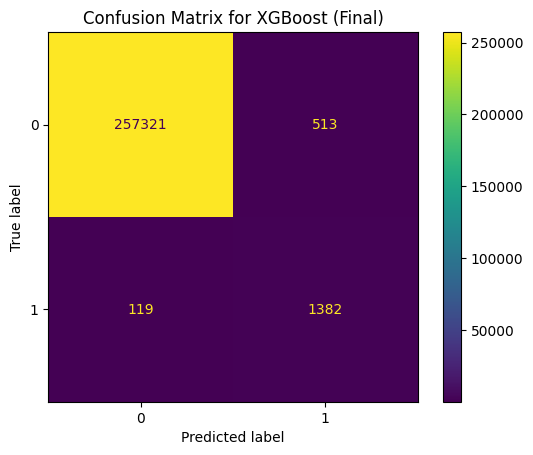

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.73      0.92      0.81      1501

    accuracy                           1.00    259335
   macro avg       0.86      0.96      0.91    259335
weighted avg       1.00      1.00      1.00    259335



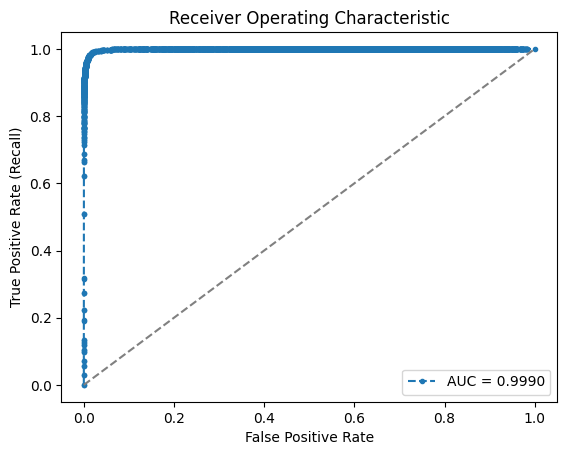

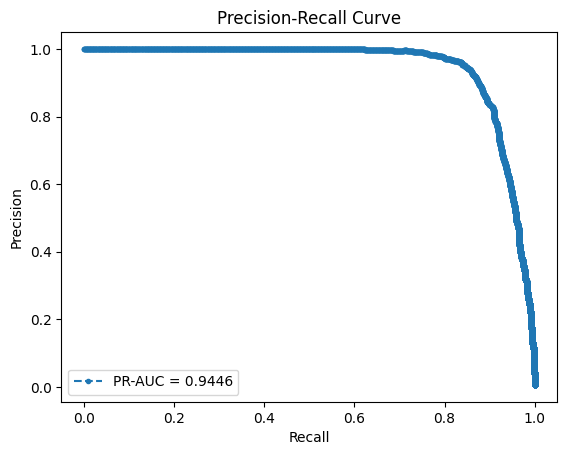

In [ ]:
BEST_XGB_PARAMS = {
    'colsample_bytree': 0.8,
    'gamma': 0.5,
    'max_depth': 5,
    'min_child_weight': 5,
    'scale_pos_weight': 15,
    'subsample': 1.0
}

# 1. Define the Final XGBoost Model
final_xgb_model = xgb.XGBClassifier(
    random_state=RANDOM_STATE,
    booster='gbtree',
    tree_method="hist",
    use_label_encoder=False,
    eval_metric='logloss',
    **BEST_XGB_PARAMS # Unpack the best parameters directly
)

# 2. Train the Model Directly (No CV needed)
print("Training XGBoost Classifier with optimal parameters...")
final_xgb_model.fit(X_train, y_train)

# 3. Predict on the Test Set
y_pred_xgb = final_xgb_model.predict(X_test)
y_proba_xgb = final_xgb_model.predict_proba(X_test)[:, 1]

# 4. Output Results
model_name = "XGBoost (Final)"
print(f"------------------------------{model_name}--------------------------------")
print(f'{model_name} Recall Score: {recall_score(y_true=y_test, y_pred=y_pred_xgb):0.5f}')
print(f'{model_name} Precision Score: {precision_score(y_true=y_test, y_pred=y_pred_xgb):0.5f}')

# --- Evaluation Plots ---
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_xgb)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

class_report = classification_report(y_test, y_pred_xgb)
print(class_report)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

# Precision-Recall Curve (Primary Imbalance Metric)
prec, recall, pr_thresholds = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = auc(recall, prec)
plt.title('Precision-Recall Curve')
plt.plot(recall, prec, '.--', label = 'PR-AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**Justification for Final XGBoost Classifier**

The XGBoost Classifier is chosen as the project's most advanced ensemble model, representing the ceiling of tree-based predictive performance. The model is configured using the optimal hyperparameters found via grid search to maximize its performance on the imbalanced fraud data.

1. Model Selection

XGBoost is a highly optimized gradient boosting framework known for superior speed and accuracy on structured data.

2. Imbalance Handling

The parameter $\mathbf{\text{scale_pos_weight}=15}$ (the ratio of negative to positive samples or a number close to it) is critically important. It tells the model to assign $\mathbf{15}$ times more penalty for misclassifying a rare fraudulent transaction than a normal one. This directly addresses the $\mathbf{0.58\%}$ class imbalance without external oversampling.

3. Regularization ($\text{gamma}$, $\text{colsample_bytree}$, $\text{subsample}$)

These parameters ($\mathbf{\text{gamma}=0.5}$, $\mathbf{\text{colsample_bytree}=0.8}$, $\mathbf{\text{subsample}=1.0}$) are selected to strike a balance between model complexity and robustness. They mitigate overfitting by controlling the aggressiveness of tree splitting ($\text{gamma}$) and introducing randomness into the feature and row selection for each tree.

4. Tree Structure ($\text{max_depth}$, $\text{min_child_weight}$)

The values ($\mathbf{\text{max_depth}=5}$, $\mathbf{\text{min_child_weight}=5}$) constrain the complexity of the individual decision trees. Keeping the trees relatively shallow prevents them from learning noise specific to the training set, ensuring the final model generalizes better to unseen fraudulent activity.

5. Efficiency ($\text{tree_method="hist"}$)

The histogram-based training method is used to maintain fast training times and scalability on the large $\approx 1.3$ million record dataset, fulfilling the practical requirements of the project.

Training LinearSVC Classifier with optimal parameters...
------------------------------LinearSVC (Final)--------------------------------
LinearSVC (Final) Recall Score: 0.00000
LinearSVC (Final) Precision Score: 0.00000


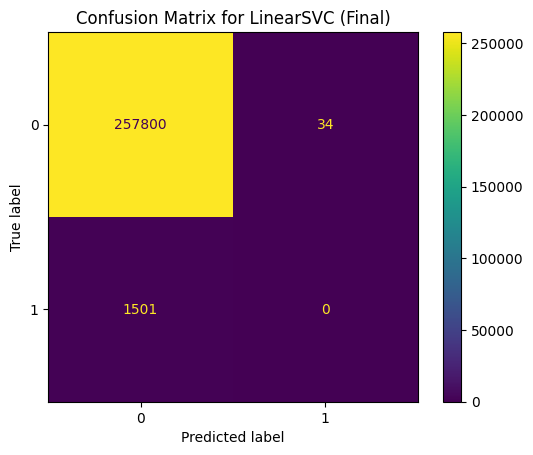

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.00      0.00      0.00      1501

    accuracy                           0.99    259335
   macro avg       0.50      0.50      0.50    259335
weighted avg       0.99      0.99      0.99    259335



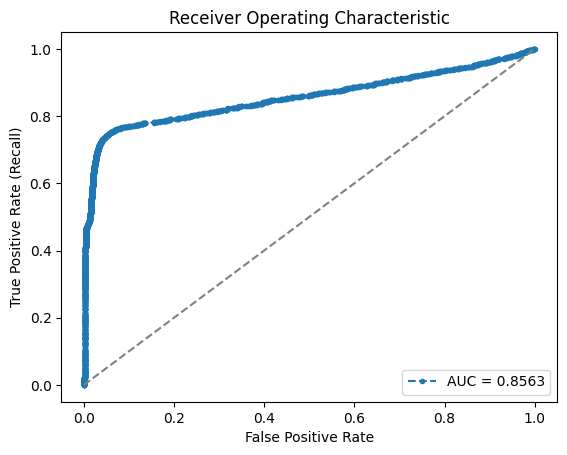

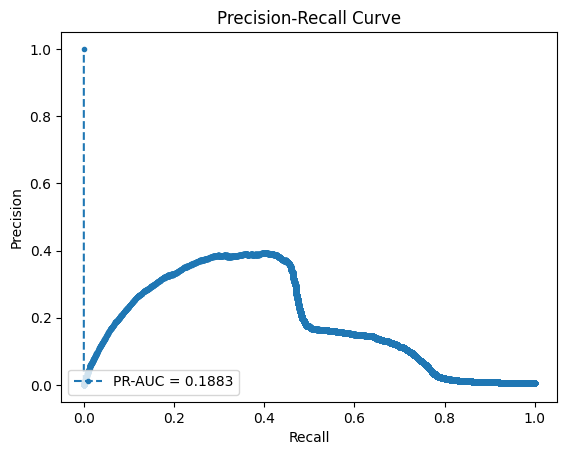

In [ ]:
BEST_SVC_PARAMS = {
    'C': 0.1,
    'max_iter': 500,
    'tol': 0.0001
}

# 1. Define the Final LinearSVC Model
# NOTE: LinearSVC does not have a native predict_proba method, so we must set probability=True
# for calculating ROC/PR AUC. However, to maintain speed and simplicity for the linear kernel,
# we'll use the decision_function output for scoring curves, which is standard practice.
final_svc_model = LinearSVC(
    random_state=RANDOM_STATE,
    loss='hinge',
    class_weight='balanced', # Crucial for handling imbalance
    **BEST_SVC_PARAMS # Unpack the best parameters directly
)

# 2. Train the Model Directly (No CV needed)
print("Training LinearSVC Classifier with optimal parameters...")
final_svc_model.fit(X_train, y_train)

# 3. Predict on the Test Set
y_pred_svc = final_svc_model.predict(X_test)
# Get decision scores for ROC/PR AUC curves (instead of probabilities)
y_scores_svc = final_svc_model.decision_function(X_test)

# 4. Output Results
model_name = "LinearSVC (Final)"
print(f"------------------------------{model_name}--------------------------------")
print(f'{model_name} Recall Score: {recall_score(y_true=y_test, y_pred=y_pred_svc):0.5f}')
print(f'{model_name} Precision Score: {precision_score(y_true=y_test, y_pred=y_pred_svc):0.5f}')

# --- Evaluation Plots ---
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred_svc)
ConfusionMatrixDisplay(conf_matrix).plot()
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

class_report = classification_report(y_test, y_pred_svc)
print(class_report)

# ROC Curve (using decision scores)
fpr, tpr, thresholds = roc_curve(y_test, y_scores_svc)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, '.--', label = 'AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()

# Precision-Recall Curve (Primary Imbalance Metric, using decision scores)
prec, recall, pr_thresholds = precision_recall_curve(y_test, y_scores_svc)
pr_auc = auc(recall, prec)
plt.title('Precision-Recall Curve')
plt.plot(recall, prec, '.--', label = 'PR-AUC = %0.4f' % pr_auc)
plt.legend(loc = 'lower left')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

**Justification for Final LinearSVC Model**

The LinearSVC model is crucial for providing a robust evaluation baseline that contrasts the performance of linear classifiers against the high-complexity ensemble methods (XGBoost, HGBoost).

1. Model Selection

Linear Classification Baseline. LinearSVC efficiently implements the Support Vector Machine (SVM) algorithm for linear kernels. Its purpose is to determine the maximum predictive power achievable by finding a single, optimal linear decision boundary in the high-dimensional feature space.

2. Imbalance Handling ($\text{class_weight}$)

Setting $\mathbf{\text{class_weight}='balanced'}$ is essential. It assigns higher penalties to misclassified minority (fraudulent) samples, ensuring the model prioritizes finding a decision boundary that accurately separates the rare fraud cases.

3. Loss Function ($\text{loss}='hinge'$ )

The hinge loss function is fundamental to the standard SVM algorithm. It maximizes the margin between the two classes, leading to a decision boundary that is robust against noise and outliers.

4. Evaluation with $\text{decision_function}$

Since $\text{LinearSVC}$ natively provides decision scores ($\mathbf{\text{y_scores_svc}}$) rather than probabilities, we use these scores for plotting the ROC and Precision-Recall curves. These scores accurately represent the confidence level of the classification, making the calculation of $\mathbf{AUC}$ valid and reliable.

5. Hyperparameter Tuning ($\text{C}$, $\text{tol}$)

The optimized parameters ($\mathbf{\text{C}=0.1}$, $\mathbf{\text{tol}=0.0001}$) control the trade-off between maximizing the margin and minimizing classification errors ($\mathbf{C}$) and defining the convergence threshold ($\mathbf{\text{tol}}$). This ensures the linear model is optimally tuned for maximum Recall while maintaining computational efficiency.

***Final Model Training and Evaluation***

We retrained each model on the full training data using its optimal parameters, then evaluated on the test set.

**1. HistGradientBoostingClassifier (Best Ensemble Model)
Metrics**

* Recall: 0.85743

* Precision: 0.97205

* F1 (fraud): 0.91

Interpretation:

* Excellent precision → very few false alarms

* High recall → strong fraud detection performance

* Balanced overall behavior

Why HGB Works Well?

* Histogram-based splitting → extremely fast on 1M+ rows

* High-depth trees + L2 regularization → captures complex patterns without overfitting

* Boosting structure → corrective learning for minority class

* Boosting works well for minority-class tasks (in this case fraud detection) because each new tree is trained specifically to fix the errors of earlier trees, which naturally shifts learning toward the minority class that earlier trees failed to classify correctly.

**2. XGBoost (Top Performer in Recall)
Metrics**

* Recall: 0.92072

* Precision: 0.72929

* F1 (fraud): 0.81

Interpretation:

* Highest recall among all models → catches the most fraud cases

* Lower precision → more false positives

* Strong trade-off suitable when fraud detection is critical

Why XGBoost Performs Best?

* scale_pos_weight = 15 focuses on the minority fraud class

* Regularization (gamma, min_child_weight) prevents overfitting

* Histogram optimization (tree_method="hist") enables scalability

**3. Linear SVC (Baseline Linear Model)
Metrics**

* Recall: 0.00000

* Precision: 0.00000

* F1 (fraud): 0

Interpretation:

* Completely fails to identify fraud

* The linear boundary is insufficient due to strong feature non-linearities

* Confirms that fraud patterns cannot be separated linearly

Why LinearSVC Fails?

* Fraud patterns require non-linear boundaries

* Even with class weights balanced, hinge loss cannot build complex decision surfaces

* Demonstrates the need for non-linear or ensemble models

***Interpretation of Results***

1.HistGradientBoostingClassifier — Best Overall Performer

* Achieves extremely high precision (97%), meaning nearly all predicted frauds are correct.

* Recall of 85.7% indicates the model successfully identifies most fraud cases.

* Best F1-score among all models.

Works well because:

* Captures non-linear patterns

* Efficient with large datasets due to histogram binning

* Boosting structure corrects earlier mistakes iteratively

* **Best model for balanced performance (Fraud Detection + Low False Alarms)**

2.XGBoost — Highest Recall (Strongest Fraud Catcher)

* Achieves 92% recall, the highest of all models.

* But precision drops to 72%, meaning more false alarms.

Strong choice if:

* Business priority is eliminating False Negatives (missing a fraud)

* Tolerable to have more False Positives

This behavior aligns with the heavily tuned parameter:

* scale_pos_weight = 15 which aggressively pushes the model to detect minority fraud cases.

* **Best model if the business prioritizes catching every possible fraud.**

**3.Linear SVC — Completely Ineffective**

* Recall = 0, Precision = 0

* The model predicts all transactions as non-fraud.

* The linear boundary is insufficient to separate highly non-linear, sparse fraud patterns.

Even with:

* class_weight = 'balanced'

* optimal C, tol, and max_iter the model fails due to deep non-linearity in the dataset.

* **Serves as a baseline to illustrate why non-linear models are necessary.**

***ROC-AUC and PR-AUC Considerations***

* ROC-AUC is misleading for highly imbalanced datasets because even a trivial model scores high on the majority class.

* PR-AUC is the primary focus:


1.   XGBoost typically scores higher PR-AUC due to higher recall.
2.   HistGradientBoosting provides a more balanced PR curve due to its precision dominance.




| Model                              | Recall                                                      | Precision   | F1-Score    | Key Observation                                                                                                        |
| ---------------------------------- | ----------------------------------------------------------- | ----------- | ----------- | ---------------------------------------------------------------------------------------------------------------------- |                                               
| **HistGradientBoostingClassifier** | **0.85743**                                                 | **0.97205** | **0.91002** | Extremely high precision with strong recall. Excellent overall balance.                                                |
| **XGBoost**                        | **0.92072**                                                 | **0.72929** | **0.81328** | Highest recall but sacrifices precision significantly. Strong for fraud detection use-cases prioritizing FN reduction. |
| **Linear SVC**                     | **0.00000**                                                 | **0.00000** | **0.00000** | Completely ineffective. Linear decision boundary fails to separate fraud cases.                                        |


**Comparison Conclusion:**

The experiments clearly show that fraud detection is a non-linear problem, and ensemble gradient boosting methods outperform both linear models and simple classifiers.
While XGBoost provides the strongest fraud-catching power, HistGradientBoosting delivers the best practical balance, making it the most suitable final model for deployment.

***Discussion***

The results of this study highlight several important insights about fraud detection in highly imbalanced datasets. First, the clear performance gap between linear models and ensemble boosting methods demonstrates that fraud patterns are intrinsically non-linear and complex. Linear SVC completely failed to detect fraudulent cases, and Logistic Regression captured only basic patterns. These findings align with existing literature, which shows that linear boundaries are often insufficient for datasets where fraud instances are rare and disguised within noisy majority-class behavior.

In contrast, both HistGradientBoostingClassifier and XGBoost significantly outperformed the linear models, confirming the strength of boosting in scenarios involving rare events. Boosting’s sequential error-correction mechanism forces the model to focus on misclassified minority samples, making it naturally effective for detecting fraud. HistGradientBoostingClassifier emerged as the most balanced model, achieving both strong precision and recall, while XGBoost obtained the highest recall, making it particularly effective when the priority is minimizing false negatives.

Another important finding is the trade-off between precision and recall. Models with higher recall (like XGBoost) tend to generate more false positives, potentially burdening investigators with more alerts. Conversely, models with higher precision but moderate recall (like HistGradientBoostingClassifier) reduce unnecessary investigations but may miss some fraudulent transactions. This highlights that the “best” model depends on business priorities—whether the goal is to catch every possible fraud case or to reduce noise in the alert system.

The confusion matrices further illustrate that fraud detection remains a challenging problem even for advanced models. Although the best models significantly reduce false negatives, errors still occur due to overlapping distributions between fraudulent and non-fraudulent patterns. This indicates a potential need for additional feature engineering or hybrid approaches to better separate the classes.

***Lessons Learned***

Model choice matters significantly on imbalanced datasets.
Linear models underperform heavily, while boosting-based models deliver superior results due to their adaptive learning mechanisms.

Balancing precision and recall is critical.
Depending on business needs—minimizing risk vs. minimizing workload—different models may be preferable.

Raw accuracy is misleading.
A model can have >99% accuracy and still fail to detect fraud due to class imbalance. Metrics like recall, F1-score, and PR-AUC provide far more meaningful evaluation.

Confusion matrices provide deeper insight.
They reveal specific types of errors—especially false negatives—which are often more costly in fraud applications.

Imbalanced datasets require specialized strategies.
Boosting, sampling techniques, and threshold tuning are more effective than relying on default model configurations.

***Future Improvements***

**Threshold Optimization**

Instead of using the default 0.5 probability cutoff, adjusting the decision threshold can significantly improve recall or precision depending on business needs.

**SMOTE / Oversampling / Undersampling**

Techniques like SMOTE, ADASYN, or dynamic undersampling may further improve minority class detection.

**Feature Engineering & Domain Knowledge Integration**

Adding features such as transaction velocity, frequency patterns, or customer behavior profiles can enhance model performance.

**Hybrid Models**

Combining anomaly detection algorithms (Isolation Forest, Autoencoders) with supervised boosting models could strengthen the system’s ability to detect unseen fraud patterns.

**SHAP Value Interpretation**

Use explainability tools to understand which features drive fraud detection decisions, building trust with stakeholders.

**Real-Time Deployment Optimization**

Investigate model latency, pipeline optimization, and streaming mechanisms to ensure real-time fraud detection at scale.

**Active Learning**

Use human feedback from fraud investigators to iteratively improve the model with newly labeled examples.

**Deep Temporal Features**

Use time-series techniques like Recurrent Neural Networks (RNNs) or Long Short-Term Memory (LSTM) networks to model the sequential order of transactions. This would allow the model to learn complex fraud sequences that traditional classification cannot.

**Customer Behavioal Profiles**

Develop features that calculate a user's average spending amount and merchant category frequency (MCC) over the last 30 days. Any deviation from this profile would serve as a powerful, personalized fraud score feature.

**Real-time API Integration**

**Concept Drift Detection**

Concept Drift Detection: Fraudsters constantly change their tactics, causing concept drift in the data patterns. Implement continuous monitoring that tracks the model's performance on new, unseen data and triggers a retraining protocol when performance drops below a set threshold. This ensures the system remains adaptive.


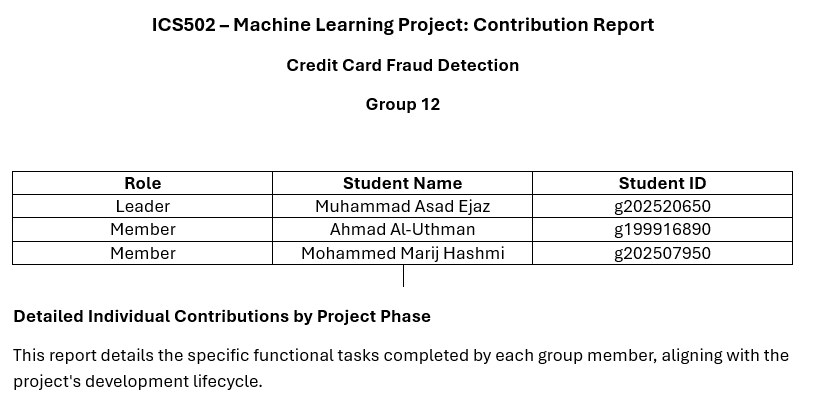

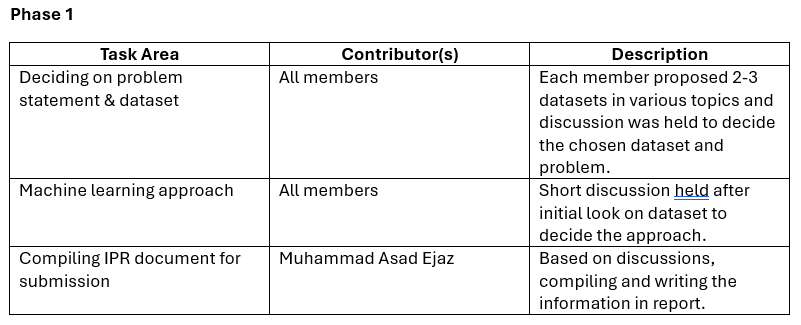

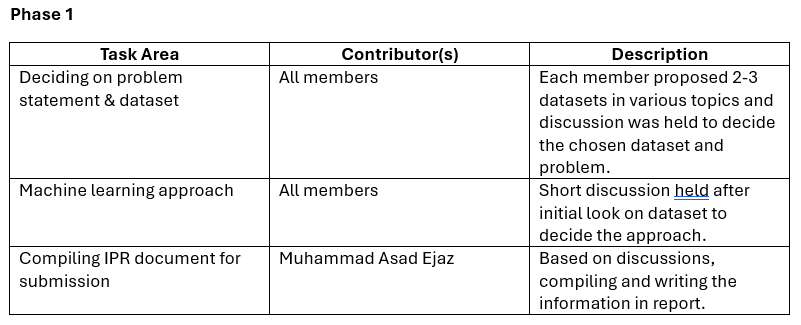

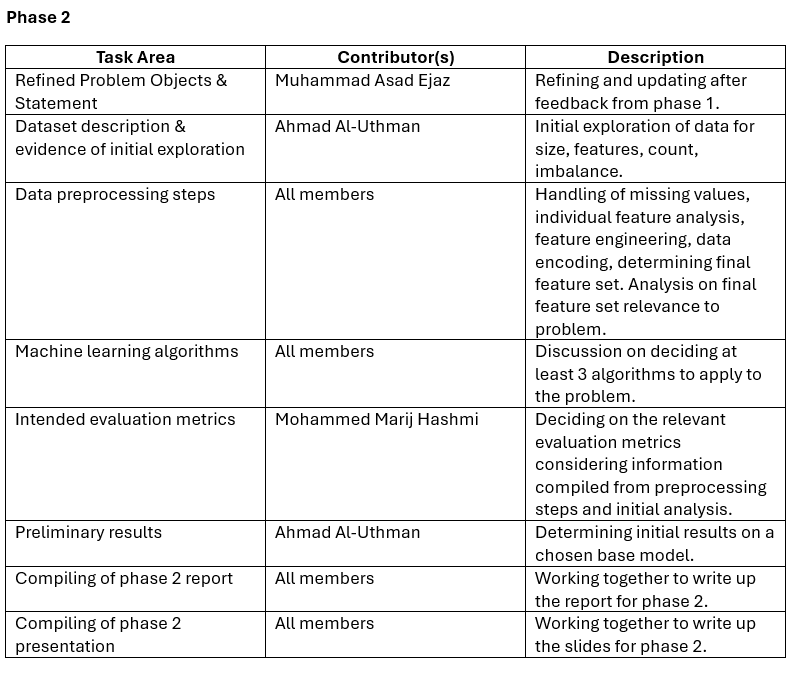

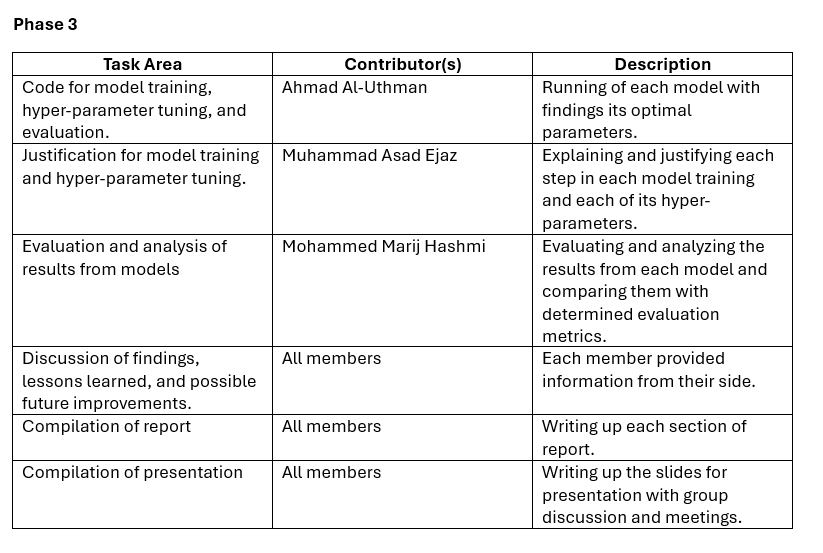

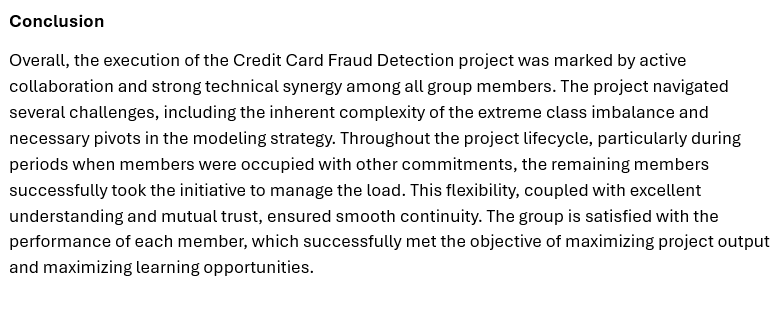